# ロジスティックモデル
種子の発芽率や生存率のように0から1の値を取る時、これらの目的変数は二項分布に従う。この時、活性化関数にロジスティック・シグモイド関数を使ったロジスティックモデルでモデル化できる。また、2クラス分類問題における確率的識別関数としてロジスティックモデルを考えることもできる(PRML 上巻 p195)。ここでは、ある植物の種子を10個蒔き、そのうち何個発芽したかという発芽率をモデル化する。

## データの説明

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymc as pm

In [6]:
germination = pd.read_csv('../data/2-5-germination.csv')

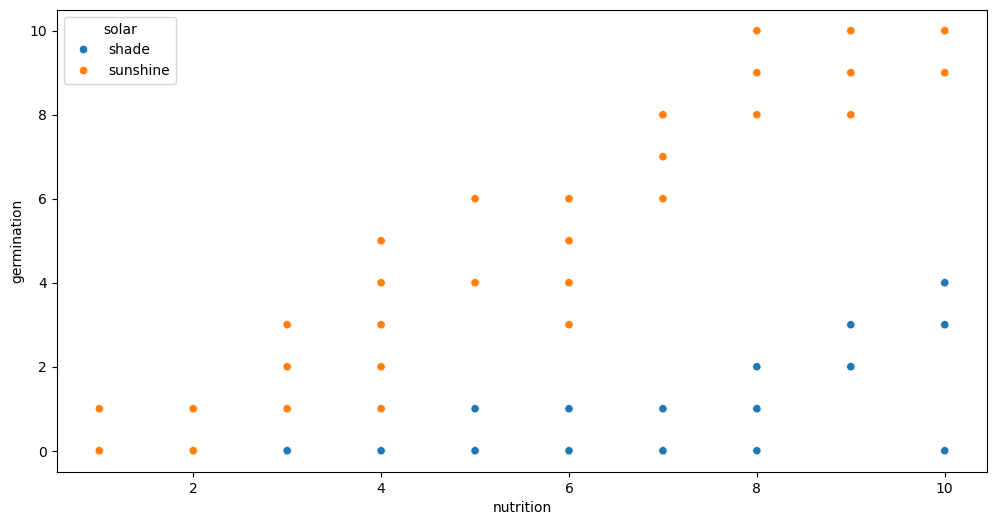

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)
plt.show()

種子の発芽数は上の図のようになり、同じ栄養量であれば日が当たっている方が発芽率が高いことが見て取れる。この関係を次のロジスティックモデルでモデル化する。
$$
p_i = \mathrm{logistic}(w_0 + w_1x_{1i} + w_2x_{2i}) \\
y_i \sim Binorm(10, p_i)
$$
ここで、$x_{1i}$は日が当たっていれば1, 当たっていなかったら0をとるダミー変数で、$x_{2i}$は栄養素の量である。これらを入力変数として、目的変数である10粒の種子のうち発芽した数$y_i$を回帰する。

ロジスティック・シグモイド関数は次のような形になり、0から1の値を取る。
$$
\mathrm{logistic}(x) = \frac{1}{1+\exp(-x)}
$$

## pymcでの実装
モデルを定義してMCMCを実行後、収束を確認する。

In [9]:
y = germination['germination'].values
nutrition = germination['nutrition'].values
solar = (germination['solar']=="sunshine").astype(int).values

In [35]:
logistic_model = pm.Model()
with logistic_model:
    # X, Yの観測値をConstantDataとして定義
    nutrition_data = pm.ConstantData('nutirion_data', nutrition)
    solar_data = pm.ConstantData('solar_data', solar)
    Y_data = pm.ConstantData('Y_data', y)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)

    # 期待値pの計算
    # pm.inlogitによって線形予測子を非線形変換
    p = pm.Deterministic("mu", pm.invlogit(w0 + w1 * solar_data + w2 * nutrition_data))

    # 観測値が従う確率分布の定義
    y_pred = pm.Binomial('y_pred', n=10, p=p, observed=Y_data)

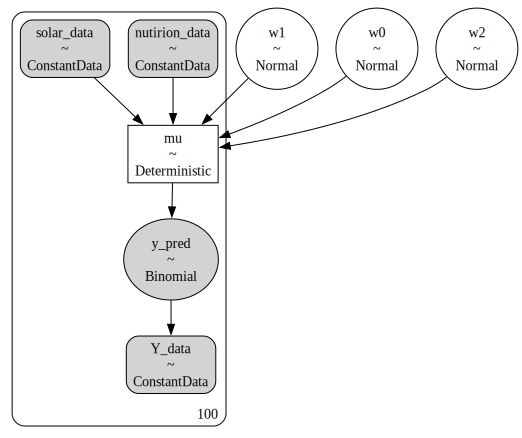

In [36]:
g = pm.model_to_graphviz(logistic_model)
display(g)

In [37]:
with logistic_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-8.018,0.500,-8.945,-7.066,0.010,0.007,2552.0,2873.0,1.0
w1,4.040,0.282,3.508,4.558,0.005,0.004,2971.0,3343.0,1.0
w2,0.720,0.053,0.626,0.828,0.001,0.001,2718.0,3526.0,1.0


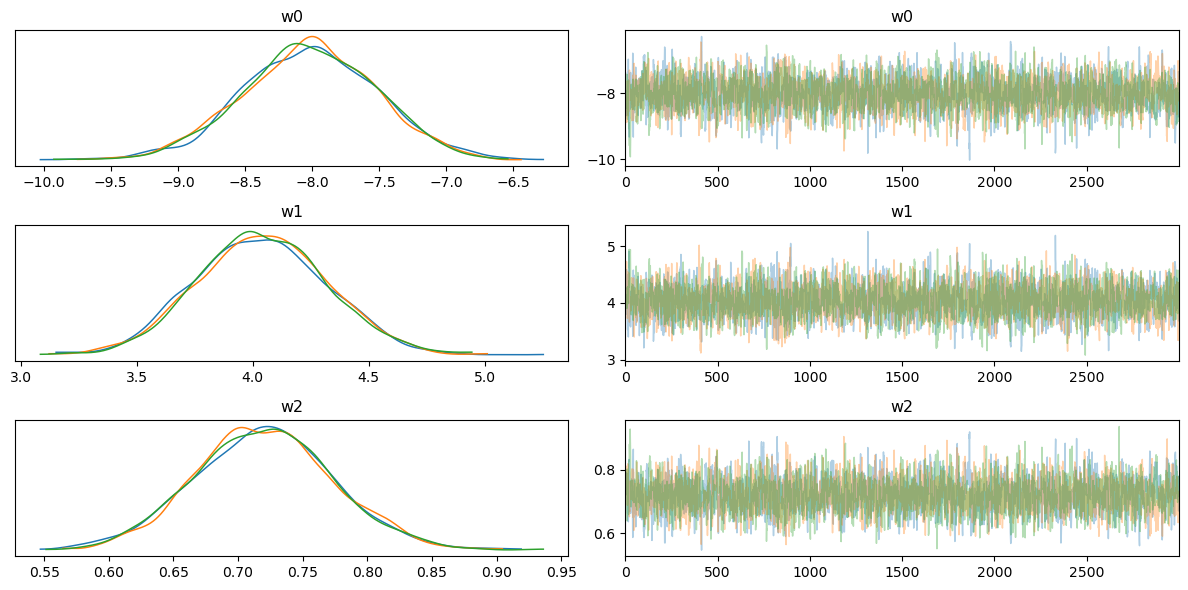

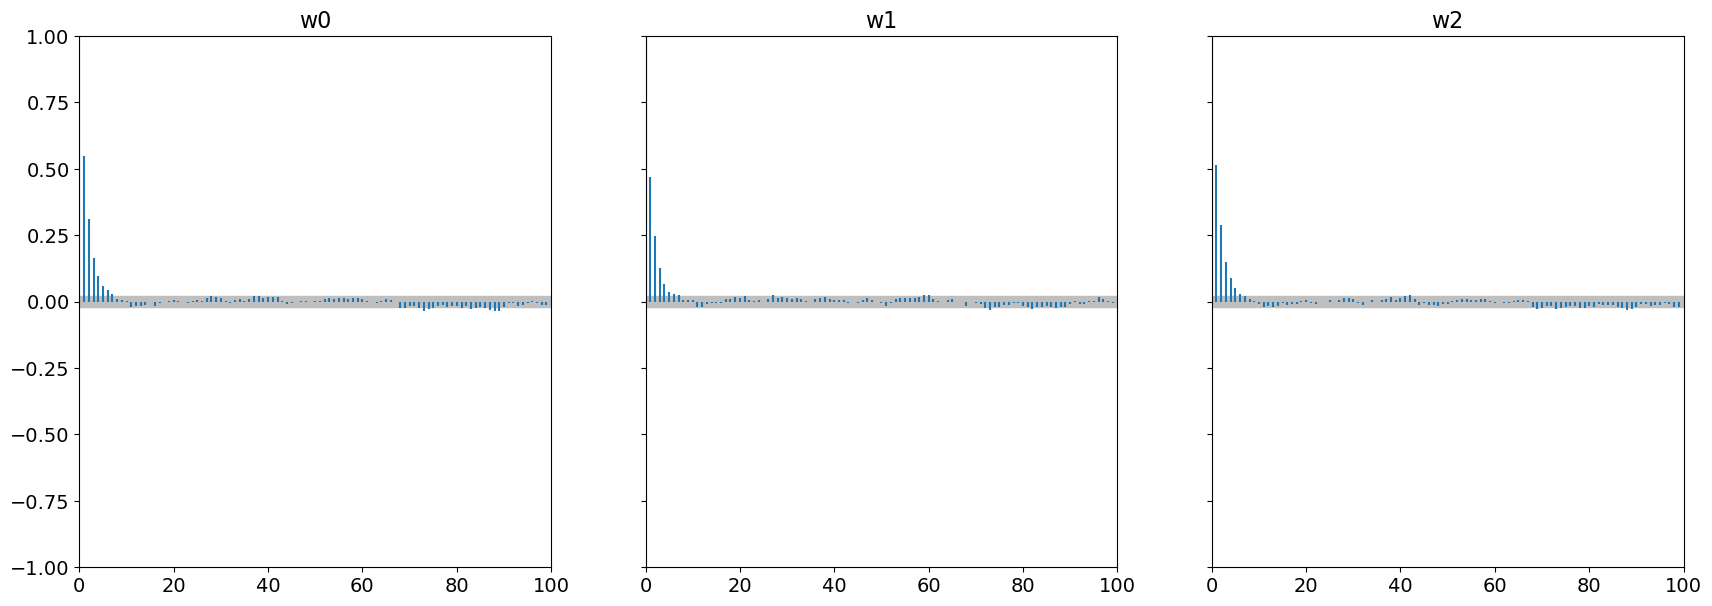

In [38]:
summary = az.summary(trace, var_names=["w0", "w1", "w2"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2"], combined=True)
plt.show()

事後分布は次のようになる。

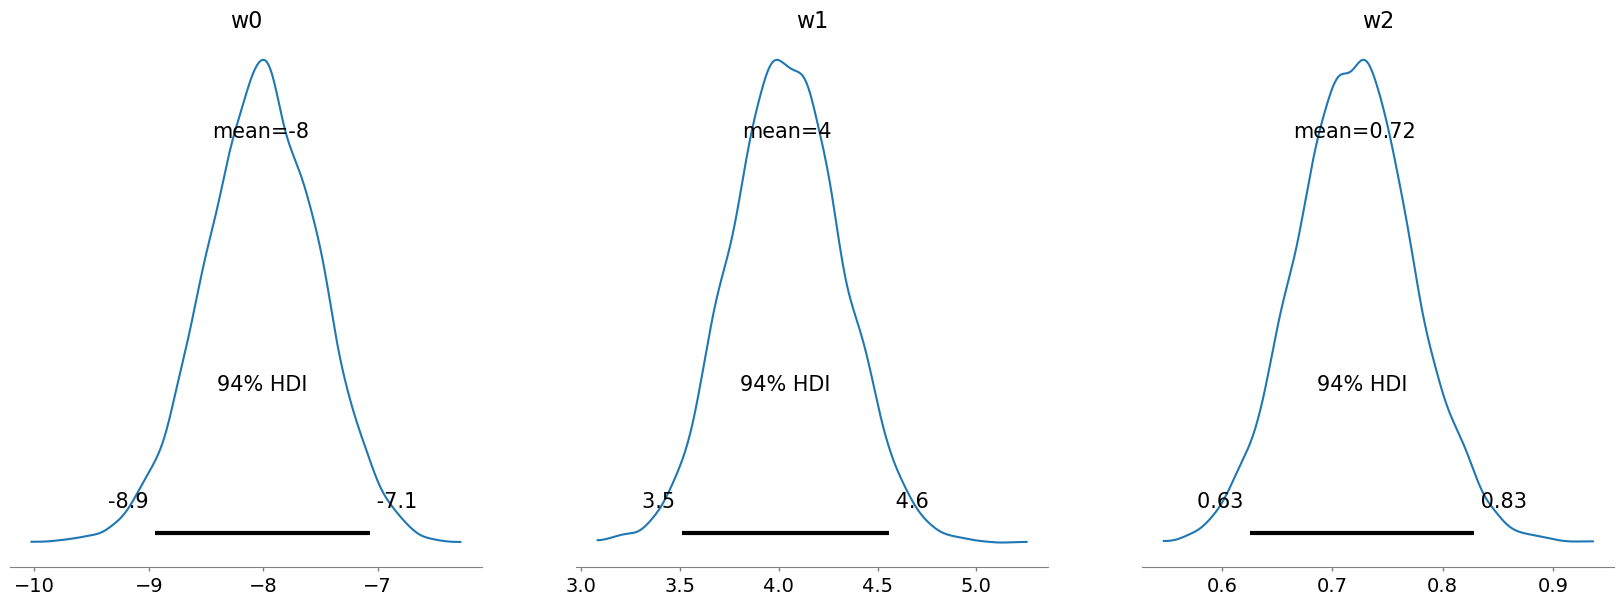

In [39]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(trace, var_names=["w0", "w1", "w2"])

### 信用区間付き回帰曲線と予測信用区間
信用区間付き回帰曲線と予測信用区間を可視化する。

In [21]:
sunshine = germination[germination.solar == "sunshine"]
shade = germination[germination.solar == "shade"]

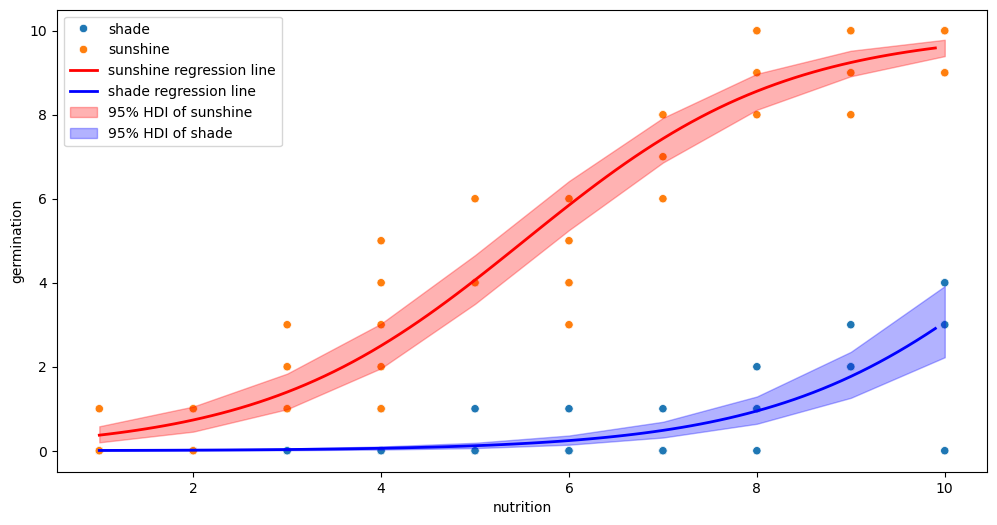

In [51]:
nutrition_values = np.arange(nutrition.min(), nutrition.max(), 0.1)
# 平均回帰曲線の計算 ロジスティック関数で変換する。また、ロジスティック関数を10倍して発芽率から発芽数に合わせている
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunshine_mean = 10*(1/(1+np.exp(-(w0_mean + w1_mean + w2_mean * nutrition_values))))
shade_mean = 10*(1/(1+np.exp(-(w0_mean + w2_mean * nutrition_values))))

# 各天気の栄養データ
sunshine_nutrition = sunshine.nutrition.values
shade_nutrition = shade.nutrition.values

#　各天気の栄養データの昇順インデックス
idx_sunshine = np.argsort(sunshine_nutrition)
idx_shade = np.argsort(shade_nutrition)

# 各天気の95% HDIの計算。ロジスティック関数を10倍しているため、HDIも10倍する
hdis = az.hdi(trace.posterior, hdi_prob=0.95)["mu"].values*10
hdi_sunshine = hdis[germination.solar == "sunshine"][idx_sunshine]
hdi_shade = hdis[germination.solar == "shade"][idx_shade]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(nutrition_values, sunshine_mean, lw=2, c='r', label='sunshine regression line')
axes.plot(nutrition_values, shade_mean, lw=2, c='b', label='shade regression line')

# 各天気の95% HDI
axes.fill_between(sunshine_nutrition[idx_sunshine], y1=hdi_sunshine[:,0], y2=hdi_sunshine[:,1], color="r", alpha=0.30, label="95% HDI of sunshine")
axes.fill_between(shade_nutrition[idx_shade], y1=hdi_shade[:,0], y2=hdi_shade[:,1], color="b", alpha=0.30, label="95% HDI of shade")
plt.legend()
plt.show()

In [45]:
myposterior= pm.sample_posterior_predictive(trace, model=logistic_model)

Sampling: [y_pred]


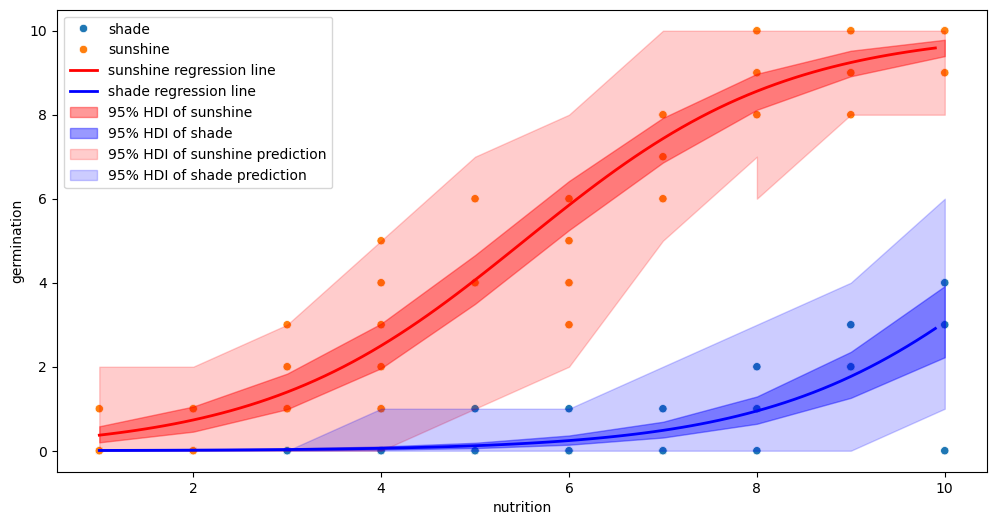

In [58]:
nutrition_values = np.arange(nutrition.min(), nutrition.max(), 0.1)
# 平均回帰曲線の計算 ロジスティック関数で変換する。また、ロジスティック関数を10倍して発芽率から発芽数に合わせている
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunshine_mean = 10*(1/(1+np.exp(-(w0_mean + w1_mean + w2_mean * nutrition_values))))
shade_mean = 10*(1/(1+np.exp(-(w0_mean + w2_mean * nutrition_values))))

# 各天気の栄養データ
sunshine_nutrition = sunshine.nutrition.values
shade_nutrition = shade.nutrition.values

#　各天気の栄養データの昇順インデックス
idx_sunshine = np.argsort(sunshine_nutrition)
idx_shade = np.argsort(shade_nutrition)


# 各天気の予測分布の95% HDIの計算。予測分布は確率ではないので10倍する必要はない
hdis = az.hdi(myposterior.posterior_predictive, hdi_prob=0.95)["y_pred"].values
hdi_sunshine_pred = hdis[germination.solar == "sunshine"][idx_sunshine]
hdi_shade_pred = hdis[germination.solar == "shade"][idx_shade]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(nutrition_values, sunshine_mean, lw=2, c='r', label='sunshine regression line')
axes.plot(nutrition_values, shade_mean, lw=2, c='b', label='shade regression line')

axes.fill_between(sunshine_nutrition[idx_sunshine], y1=hdi_sunshine[:,0], y2=hdi_sunshine[:,1], color="r", alpha=0.40, label="95% HDI of sunshine")
axes.fill_between(shade_nutrition[idx_shade], y1=hdi_shade[:,0], y2=hdi_shade[:,1], color="b", alpha=0.40, label="95% HDI of shade")

# 各天気の95% HDI
axes.fill_between(sunshine_nutrition[idx_sunshine], y1=hdi_sunshine_pred[:,0], y2=hdi_sunshine_pred[:,1], color="r", alpha=0.20, label="95% HDI of sunshine prediction")
axes.fill_between(shade_nutrition[idx_shade], y1=hdi_shade_pred[:,0], y2=hdi_shade_pred[:,1], color="b", alpha=0.20, label="95% HDI of shade prediction")
plt.legend()
plt.show()

## モデルの解釈

ロジスティックモデルでは活性化関数にロジスティック・シグモイド関数を利用しており、係数の解釈が難しい。ここで、活性化関数の逆関数であるリンク関数の視点で考える。活性化関数によってモデルは次のようにかける。
$$
p = \mathrm{logistic}(w_0 + w_1x_{1} + w_2x_{2})
$$
ここで、ロジスティック・シグモイド関数の逆関数であるロジット関数をリンク関数とすると次のように書き換えられる。
$$
\mathrm{logit}(p) = \ln\Bigl(\frac{p}{1-p}\Bigr) = w_0 + w_1x_{1} + w_2x_{2}
$$
ここで、次の指標をオッズと言い、失敗するよりも何倍成功しやすいかを表す。このオッズの変化率をオッズ比と呼ぶ。
$$
\frac{p}{1-p}
$$
ある入力$(x_{11},x_{21})$によって回帰された$p$を$p_1$, $(x_{12},x_{22})$によって回帰された$p$を$p_2$とすると、対数オッズ比は次のようになる。
$$
\ln\Bigl(\frac{p_2}{1-p_2}\Bigl/\frac{p_1}{1-p_1}\Bigr) = \ln\Bigl(\frac{p_2}{1-p_2}\Bigr) - \ln\Bigl(\frac{p_1}{1-p_1}\Bigr) = w_1(x_{12} - x_{11}) + w_2(x_{22} - x_{21})
$$
$x_{12} - x_{11} = 1, x_{22} - x_{21} = 0$とすると、対数オッズ比は$w_1$となり、回帰係数は対数オッズ比であると解釈できる。つまり、回帰係数を指数関数にかけたものがオッズ比となる。

今回のモデルでは、$w_1$の期待値は4.04となるので、オッズ比は$\exp(4.04)=56.83$となる。よって日が当たる時と日が当たらない時のオッズ比は56.83になる。また、$w_2$の期待値は0.72となるので、栄養量が1増えた時の、オッズ比は2.05となる。

## pystanでの実装

In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [4]:
germination = pd.read_csv('../data/2-5-germination.csv')

In [5]:
germination

,germination,size,solar,nutrition
0,0,10,shade,1
1,0,10,shade,1
2,0,10,shade,1
3,0,10,shade,1
4,0,10,shade,1
...,...,...,...,...
95,9,10,sunshine,10
96,10,10,sunshine,10
97,10,10,sunshine,10
98,9,10,sunshine,10


In [6]:
y = germination['germination'].values
nutrition = germination['nutrition'].values.reshape(-1, 1)
solar = (germination['solar']=="sunshine").astype(int).values.reshape(-1, 1)
X = np.concatenate([np.ones_like(y).reshape(-1, 1), solar, nutrition], axis=1)
N = len(y)
K = X.shape[1]
binom_size = germination['size'].values
#binom_size = 10

nutrition_pred = np.tile(np.linspace(nutrition.min(), nutrition.max(), 100), 2).reshape(-1, 1)
solar_pred = np.array([1]*100 + [0]*100).reshape(-1, 1)
X_pred = np.concatenate([np.ones_like(solar_pred), solar_pred, nutrition_pred], axis=1)
N_pred = len(X_pred)
binom_size_pred = np.array([10]*100 + [10]*100)

In [7]:
stan_data = {
    'N': N,
    'K': K,
    'X': X,
    'y': y,
    'binom_size': binom_size,
    "N_pred": N_pred,
    "X_pred": X_pred,
    "binom_size_pred": binom_size_pred
}

In [8]:
with open('../stan/2-5-logistic-model.stan') as f:
    stan_code = f.read()

In [9]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [10]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-8.020,0.509,-9.000,-7.109,0.009,0.007,3061.0,3992.0,1.0
beta[1],4.043,0.288,3.512,4.582,0.005,0.003,3450.0,4422.0,1.0
beta[2],0.720,0.054,0.618,0.819,0.001,0.001,3420.0,4665.0,1.0


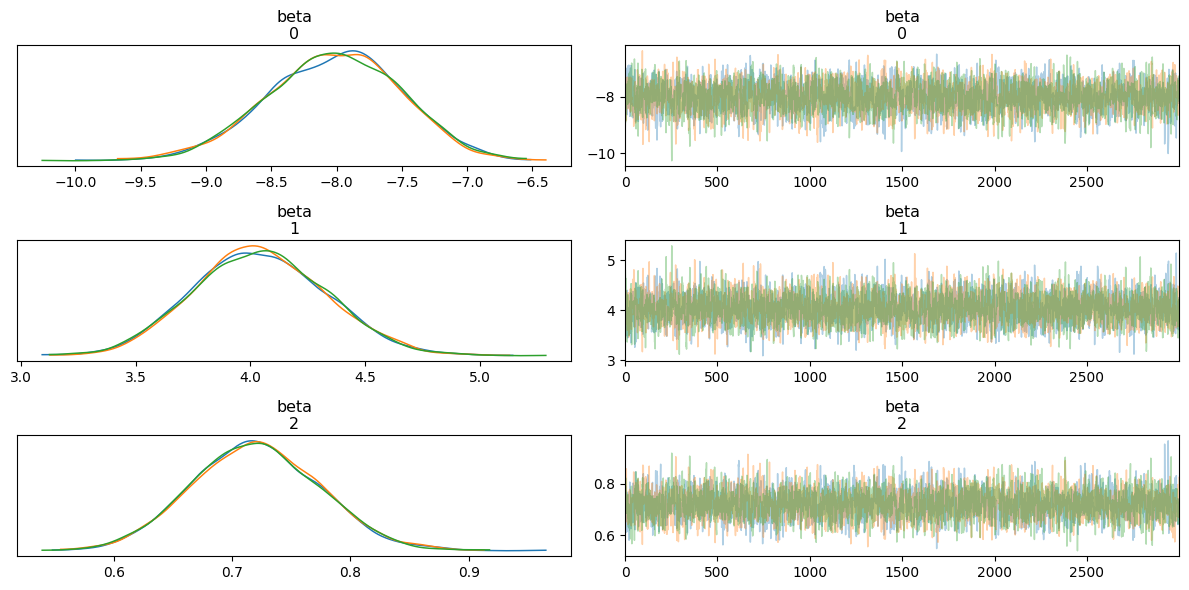

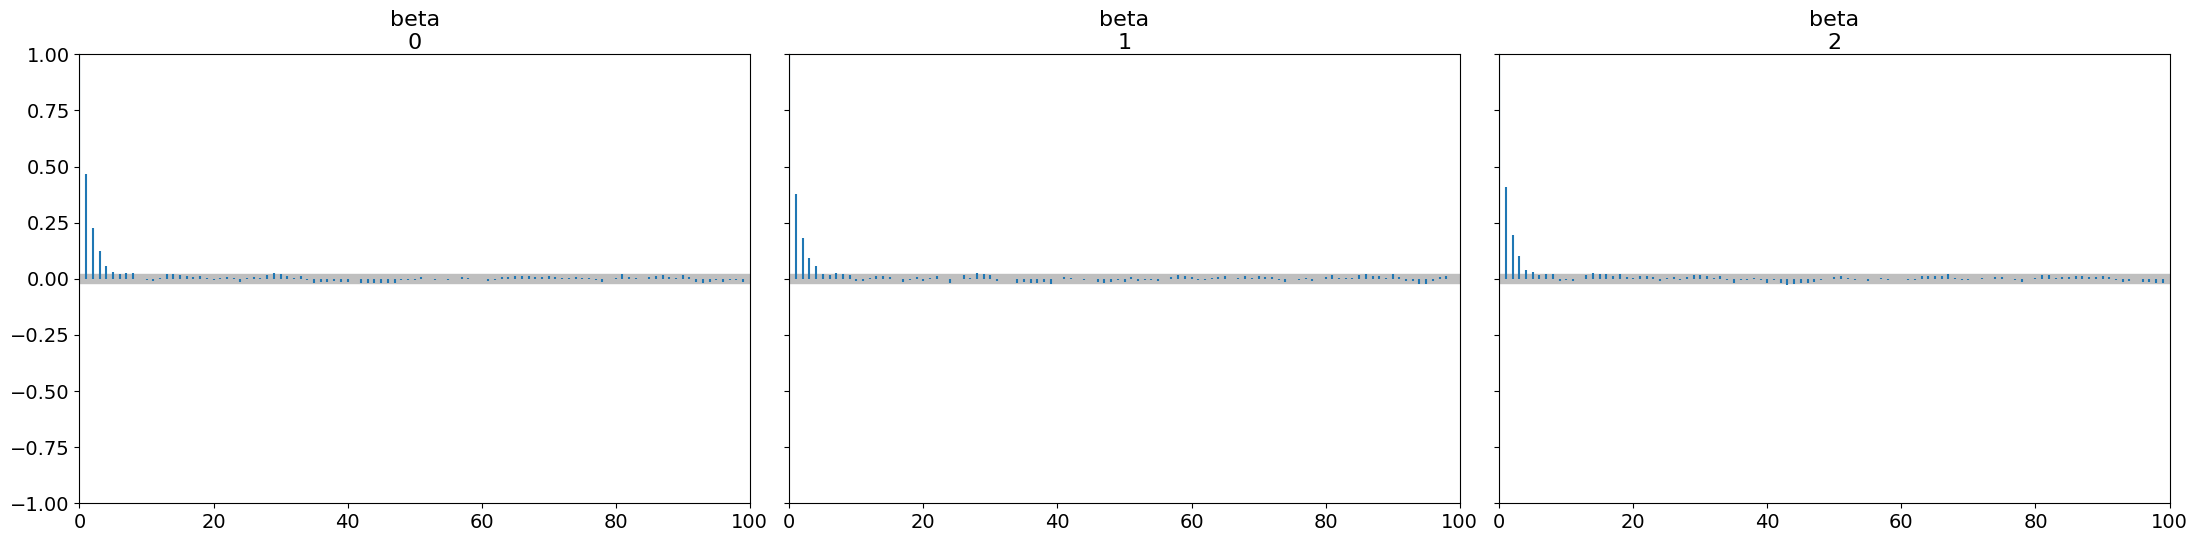

In [12]:
summary = az.summary(fit, var_names=["beta"])
display(summary)
az.plot_trace(fit, var_names=["beta"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta"], combined=True)
plt.tight_layout()

In [13]:
nut_values = X_pred[:100, -1]
sunshine_idx = X_pred[:, 1]==1
shade_idx = X_pred[:, 1]==0

sunshine_X = X_pred[sunshine_idx]
shade_X = X_pred[shade_idx]

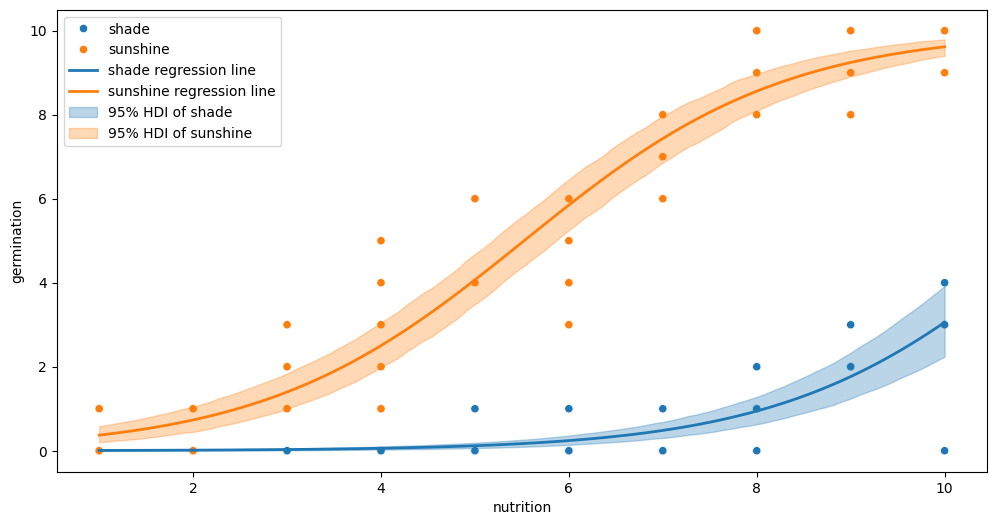

In [15]:
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
beta = summary["mean"][summary.index.str.contains("beta")].values
sunshine_mean = 10/(1+np.exp(-np.dot(sunshine_X, beta)))
shade_mean = 10/(1+np.exp(-np.dot(shade_X, beta)))

# 各天気の95% HDIの計算
hdis = az.hdi(fit, hdi_prob=0.95)["p_pred"].values * 10
hdi_sunshine = hdis[sunshine_idx]
hdi_shade = hdis[shade_idx]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(nut_values, shade_mean, lw=2, c=cmap(0), label='shade regression line')
axes.plot(nut_values, sunshine_mean, lw=2, c=cmap(1), label='sunshine regression line')


# 各天気の95% HDI
axes.fill_between(nut_values, y1=hdi_shade[:,0], y2=hdi_shade[:,1], color=cmap(0), alpha=0.30, label="95% HDI of shade")
axes.fill_between(nut_values, y1=hdi_sunshine[:,0], y2=hdi_sunshine[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunshine")
plt.legend()
plt.show()

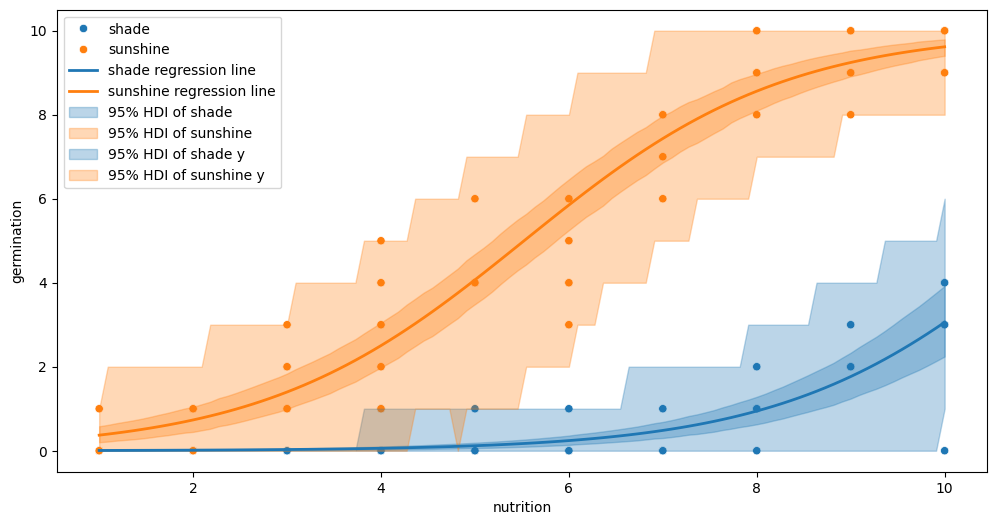

In [17]:
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
beta = summary["mean"][summary.index.str.contains("beta")].values
sunshine_mean = 10/(1+np.exp(-np.dot(sunshine_X, beta)))
shade_mean = 10/(1+np.exp(-np.dot(shade_X, beta)))

# 各天気の95% HDIの計算
hdis_p = az.hdi(fit, hdi_prob=0.95)["p_pred"].values * 10
hdi_sunshine_p = hdis_p[sunshine_idx]
hdi_shade_p = hdis_p[shade_idx]

hdis_y = az.hdi(fit, hdi_prob=0.95)["y_pred"].values
hdi_sunshine_y = hdis_y[sunshine_idx]
hdi_shade_y = hdis_y[shade_idx]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(nut_values, shade_mean, lw=2, c=cmap(0), label='shade regression line')
axes.plot(nut_values, sunshine_mean, lw=2, c=cmap(1), label='sunshine regression line')


# 各天気の95% HDI
axes.fill_between(nut_values, y1=hdi_shade_p[:,0], y2=hdi_shade_p[:,1], color=cmap(0), alpha=0.30, label="95% HDI of shade")
axes.fill_between(nut_values, y1=hdi_sunshine_p[:,0], y2=hdi_sunshine_p[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunshine")

# 各天気の95% HDI
axes.fill_between(nut_values, y1=hdi_shade_y[:,0], y2=hdi_shade_y[:,1], color=cmap(0), alpha=0.30, label="95% HDI of shade y")
axes.fill_between(nut_values, y1=hdi_sunshine_y[:,0], y2=hdi_sunshine_y[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunshine y")
plt.legend()
plt.show()

In [ ]:
nutrition_values = np.arange(nutrition.min(), nutrition.max(), 0.1)
# 平均回帰曲線の計算 ロジスティック関数で変換する。また、ロジスティック関数を10倍して発芽率から発芽数に合わせている
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunshine_mean = 10*(1/(1+np.exp(-(w0_mean + w1_mean + w2_mean * nutrition_values))))
shade_mean = 10*(1/(1+np.exp(-(w0_mean + w2_mean * nutrition_values))))

# 各天気の栄養データ
sunshine_nutrition = sunshine.nutrition.values
shade_nutrition = shade.nutrition.values

#　各天気の栄養データの昇順インデックス
idx_sunshine = np.argsort(sunshine_nutrition)
idx_shade = np.argsort(shade_nutrition)


# 各天気の予測分布の95% HDIの計算。予測分布は確率ではないので10倍する必要はない
hdis = az.hdi(myposterior.posterior_predictive, hdi_prob=0.95)["y_pred"].values
hdi_sunshine_pred = hdis[germination.solar == "sunshine"][idx_sunshine]
hdi_shade_pred = hdis[germination.solar == "shade"][idx_shade]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='nutrition', y='germination', data=germination, hue="solar", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(nutrition_values, sunshine_mean, lw=2, c='r', label='sunshine regression line')
axes.plot(nutrition_values, shade_mean, lw=2, c='b', label='shade regression line')

axes.fill_between(sunshine_nutrition[idx_sunshine], y1=hdi_sunshine[:,0], y2=hdi_sunshine[:,1], color="r", alpha=0.40, label="95% HDI of sunshine")
axes.fill_between(shade_nutrition[idx_shade], y1=hdi_shade[:,0], y2=hdi_shade[:,1], color="b", alpha=0.40, label="95% HDI of shade")

# 各天気の95% HDI
axes.fill_between(sunshine_nutrition[idx_sunshine], y1=hdi_sunshine_pred[:,0], y2=hdi_sunshine_pred[:,1], color="r", alpha=0.20, label="95% HDI of sunshine prediction")
axes.fill_between(shade_nutrition[idx_shade], y1=hdi_shade_pred[:,0], y2=hdi_shade_pred[:,1], color="b", alpha=0.20, label="95% HDI of shade prediction")
plt.legend()
plt.show()